In [19]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [112]:
prefix="find-max"
prefix='cryptonce-kernel'
prefix='cryptonce-max'
prefix='cryptonce-max-5g'
prefix='cryptonce-v2-trace'
prefix='cryptonce-final'
prefix='cryptonce-v2'
prefix='gonogo-2'

In [113]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).median(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir):
    cpu_csv = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    
    return latency_df

In [114]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, suffix = test_config.split('--')
        crypted = suffix.split('-')[0]
        threaded = "-".join(suffix.split('-')[1:])
#         threaded = len(suffix.split('-')[1:]) == 2
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, threaded

In [115]:
def describe_test(test, cpu=-1, throuhgput='rxkB/s', ylim_cpu=[-1, 30], ylim_net=[-0.2, 5], client=100):
    res_dir = test[0]
    print(test[1])
    global_cpu, per_core_cpu = import_cpu(res_dir)
    df = per_core_cpu.groupby('client').sum(numeric_only=True).reset_index()
    print(df[['client', 'used']])

    cpu_csv = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu_csv['used'] = 100 - cpu_csv['idle']
    cpu_csv = cpu_csv[cpu_csv.core == cpu].reset_index(drop=True)
    
    cpu_csv_1 = cpu_csv[cpu_csv.client == client].reset_index(drop=True).reset_index()

    ax = cpu_csv_1.plot(x='index', y='used', grid=True, ylabel='CPU usage', ylim=ylim_cpu, xlabel='Time in S', label=test[1])

    latency = import_latency(res_dir)
    print(latency[['client', 'mean', 'median', '90th', '99th']])
    
    res_dir = test[0]
    print(test[1])
    net_wg, net_phy = import_throughput(res_dir)
    print(net_wg[['client', throuhgput]])

    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")

    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1'] 

    throughput_wg_1 = throughput_wg[throughput_wg.client == client].reset_index(drop=True).reset_index()

    ax = throughput_wg_1.plot(x='index', y=throuhgput, grid=True, ylabel='Throuhgput (in Gbps)', ylim=ylim_net, xlabel='Time in S', label=test[1])

In [116]:
def compute_differences(df_1, df_2):
    res_dir_1 = df_1[0]
    res_dir_2 = df_2[0]
    print(f"{df_1[1]}; {df_2[1]} no - yes")
    
    throughput = 'rxkB/s' if df_1[1].startswith('upload') else 'txkB/s'
    
    # Setup the baseline
    if "-yes-" in df_1[1]:
        baseline, other = res_dir_1, res_dir_2
    else:
        baseline, other = res_dir_2, res_dir_1
    
    print('\n')
    print("CPU Difference")
    # Compute CPU difference
    global_base, pcpu_base = import_cpu(baseline)
    global_other, pcpu_other = import_cpu(other)
    
    df_base = pcpu_base.groupby('client').sum(numeric_only=True).reset_index().set_index('client')
    df_other = pcpu_other.groupby('client').sum(numeric_only=True).reset_index().set_index('client')
    
    diff = df_other - df_base 
    print("Absolute difference:")
    print(diff['used'] / 18)
    print()
    diff = diff * 100 / df_base
    print("Relative difference:")
    print(diff['used'])

    print('\n')
    print("Latency Difference")
    # Compute latency difference
    lat_base = import_latency(baseline).set_index('client')
    lat_other = import_latency(other).set_index('client')
    cols = ['mean', 'median', '90th', '99th']
    
    diff_lat = lat_other - lat_base 
    print("Absolute difference:")
    print(diff_lat[cols])
    print()
    diff_lat = diff_lat * 100 / lat_base
    print("Relative difference:")
    print(diff_lat[cols])

    # Compute Throuhgput difference
    net_wg_base, net_phy_base = import_throughput(baseline)
    net_wg_other, net_phy_other = import_throughput(other)
    net_wg_base = net_wg_base.set_index('client')
    net_wg_other = net_wg_other.set_index('client')
    
    print('\n')
    print("Throuhgput Difference")
    diff_net =  net_wg_other - net_wg_base
    print("Absolute difference:")
    print(diff_net[throughput])
    print()
    diff_net = diff_net * 100 / net_wg_base
    print("Relative difference:")
    print(diff_net[throughput])

    return diff, diff_lat, diff_net

In [117]:
# reslv_res_name(f"{prefix}/results-8b3cc625")

In [118]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [119]:
# resdir = f"{prefix}/results-410d4199"
# net_wg, net_phy = import_throughput(resdir)

In [120]:
# gcpu, pcpu = import_cpu(resdir)

In [121]:
# gcpu.plot(x='client', y='used', grid=True, marker='x', ylim=[-10, 110])

In [122]:
# list(enumerate(res_dirs))

In [123]:
# 1. find yes and put it at start
# 2. find no and put it at second

def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res[4] == val:
            return k
index = find_index(res_dirs, 'no')
no = res_dirs.pop(index)
res_dirs.insert(0, no)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)

In [124]:
list(enumerate(res_dirs))

[(0,
  ('gonogo-2/results-0d04f53b',
   'upload--yes-kernel-v1',
   'upload',
   '600Mbits',
   'yes',
   'kernel-v1')),
 (1,
  ('gonogo-2/results-3a104efa',
   'upload--no-kernel-v1',
   'upload',
   '600Mbits',
   'no',
   'kernel-v1'))]

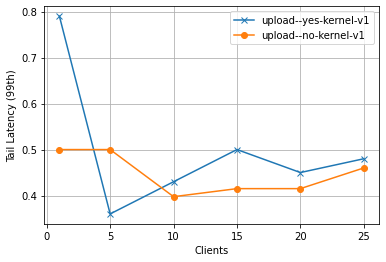

In [125]:
res_dir = res_dirs[0]
ms = ['x', 'o', 's']
df = import_latency(res_dir[0])
ax = df.plot(x='client', y='99th', ylim=None, grid=True, marker=ms[0],
            ylabel="Tail Latency (99th)", xlabel="Clients", label=res_dir[1])
for k, res in enumerate(res_dirs[1:]):
    df = import_latency(res[0])
    df.plot(ax=ax, x='client', y='99th', ylim=None, grid=True, marker=ms[k+1],
            ylabel="Tail Latency (99th)", xlabel="Clients", label=res[1])
plt.show()

upload--yes-kernel-v1
    cpu  client  core  run  usr  kernel  softirq    idle    used
0    18       1    -1  2.0  0.0   3.020    2.245  94.445   5.555
19   18       5    -1  2.0  0.0   5.210    5.475  89.525  10.475
38   18      10    -1  2.0  0.0   8.890   10.465  80.660  19.340
57   18      15    -1  2.0  0.0  15.135   16.295  68.475  31.525
76   18      20    -1  2.0  0.0  28.600   28.990  42.175  57.825
95   18      25    -1  2.0  0.0  33.835   42.295  24.205  75.795
upload--no-kernel-v1
    cpu  client  core  run  usr  kernel  softirq    idle    used
0    18       1    -1  2.0  0.0   1.000    1.770  97.245   2.755
19   18       5    -1  2.0  0.0   3.710    6.970  89.360  10.640
38   18      10    -1  2.0  0.0  16.380   17.540  65.325  34.675
57   18      15    -1  2.0  0.0  13.745   22.040  64.180  35.820
76   18      20    -1  2.0  0.0  23.470   28.445  48.265  51.735
95   18      25    -1  2.0  0.0  33.955   35.810  29.350  70.650


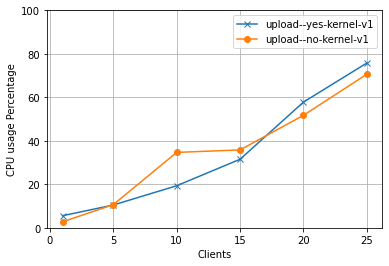

In [129]:
res_dir = res_dirs[0]
ms = ['x', 'o', 's']
df = import_cpu(res_dir[0])[0]
ax = df.plot(x='client', y='used', ylim=[0, 100], grid=True, 
                 marker=ms[0],
            ylabel="CPU usage Percentage", xlabel="Clients", label=res_dir[1])
print(res_dir[1])
print(df)
for k, res in enumerate(res_dirs[1:]):
    df = import_cpu(res[0])[0]
    df.plot(ax=ax, x='client', y='used', ylim=[0, 100], grid=True, 
                marker=ms[k+1],
            ylabel="CPU usage Percentage", xlabel="Clients", label=res[1])
    print(res[1])
    print(df)
plt.show()

,clients,upload--no-kernel-v1
0,1,50.405041
1,5,-1.575179
2,10,-79.291624
3,15,-13.624108
4,20,10.531777
5,25,6.788047


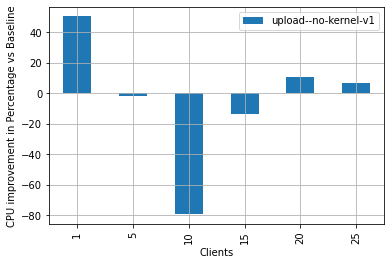

In [127]:
res_dir = res_dirs[0]
ms = ['x', 'o', 's']
df_base = import_cpu(res_dir[0])[0].set_index('client')
other = res_dirs[1]
df_other = import_cpu(other[0])[0].set_index('client')
diff = (- df_other + df_base) * 100 / df_base

clients = list(diff.index)
data_ = list(diff.used)
data = {
    'clients': clients,
    other[1]: data_
}

if len(res_dirs) >= 3:
    for k, res in enumerate(res_dirs[2:]):
        other = res
        df_other = import_cpu(other[0])[0].set_index('client')
        diff = (- df_other + df_base) * 100 / df_base
        data[res[1]] = list(diff.used)

out = pd.DataFrame(data)
names = [res[1] for res in res_dirs[1:]]
out.plot.bar(
    x='clients', y=names, grid=True,
    xlabel="Clients", ylabel="CPU improvement in Percentage vs Baseline")
out

upload--yes-kernel-v1
   cpu  client  run    rxpck/s  txpck/s     rxkB/s    txkB/s  expected
0   18       1  2.0    54912.0   2236.0   0.621782  0.001677       1.0
1   18       5  2.0   274656.0  14051.0   3.109996  0.010538       5.0
2   18      10  2.0   549323.0  29457.0   6.220118  0.022093      10.0
3   18      15  2.0   823964.5  46432.5   9.329950  0.034827      15.0
4   18      20  2.0  1098674.5  63870.0  12.440558  0.047919      20.0
5   18      25  2.0  1373313.5  95809.5  15.550359  0.071975      25.0
upload--no-kernel-v1
   cpu  client  run    rxpck/s  txpck/s     rxkB/s    txkB/s  expected
0   18       1  2.0    54912.0   2028.0   0.621782  0.001521       1.0
1   18       5  2.0   274658.0  12587.0   3.110009  0.009457       5.0
2   18      10  2.0   549318.5  27113.5   6.220064  0.020335      10.0
3   18      15  2.0   823993.5  42314.0   9.330278  0.031737      15.0
4   18      20  2.0  1098642.5  60108.5  12.440195  0.045087      20.0
5   18      25  2.0  1373304.0  83

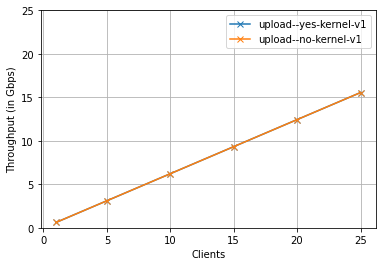

In [128]:
res_dir = res_dirs[0]
ms = ['x', 'o', 's']
df = import_throughput(res_dir[0])[0]
ax = df.plot(x='client', y='rxkB/s', ylim=[0, 100], grid=True, marker=ms[0],
            ylabel="Throughput (in Gbps)", xlabel="Clients", label=res_dir[1])
print(res_dir[1])
print(df)
for res in res_dirs[1:]:
    df = import_throughput(res[0])[0]
    df.plot(ax=ax, x='client', y='rxkB/s', ylim=[0, 25], grid=True, marker=ms[0],
            ylabel="Throughput (in Gbps)", xlabel="Clients", label=res[1])
    print(res[1])
    print(df)

<AxesSubplot: xlabel='core'>

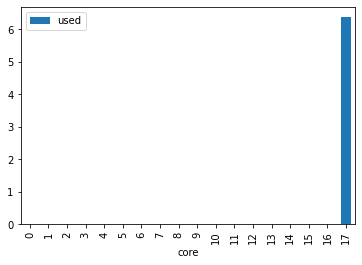

In [435]:
pcpu = import_cpu(res_dirs[1][0])[1]

pcpu_20 = pcpu[pcpu.client == 1]
pcpu_20.plot.bar(x='core', y='used')

In [436]:
import_throughput(res_dirs[0][0])[0]

,cpu,client,run,rxpck/s,txpck/s,rxkB/s,txkB/s,expected
0,18,1,2.0,27456.0,697.000,0.310891,0.000523,1.0
1,18,10,2.0,274657.5,14128.000,3.110013,0.010622,10.0
2,18,20,2.0,549297.0,31678.000,6.219822,0.023758,20.0
3,18,40,2.0,1098586.5,65183.500,12.439557,0.048888,40.0
4,18,60,2.0,1647890.0,102916.500,18.659460,0.077187,60.0
5,18,80,2.0,2046924.0,197491.625,23.218307,0.148235,80.0


In [268]:
# import_latency(res_dirs[1][0])

In [287]:
diff_cpu, diff_lat, diff_nett = compute_differences(res_dirs[0], res_dirs[1])

upload--yes-kernel-v2; upload--no-kernel-v2 no - yes


CPU Difference
Absolute difference:
client
1      0.326389
10    -3.237500
20    -7.005833
40    -9.230000
60   -15.664167
80   -17.216667
Name: used, dtype: float64

Relative difference:
client
1     1163.366337
10     -68.627451
20     -59.924444
40     -36.047256
60     -39.994468
80     -32.100185
Name: used, dtype: float64


Latency Difference
Absolute difference:
           mean  median   90th   99th
client                               
1       0.02320  0.0100 -0.010 -0.010
10     -0.01855  0.0125 -0.030 -0.030
20     -0.03100 -0.0430 -0.025 -0.025
40     -0.04480 -0.0050 -0.100 -0.100
60     -0.09500 -0.0650 -0.130 -0.130
80     -0.07790 -0.0550 -0.190 -0.190

Relative difference:
             mean     median       90th       99th
client                                            
1        8.027682   3.846154  -2.500000  -2.500000
10      -6.290268   5.263158  -8.000000  -8.000000
20     -11.101164 -16.996047  -6.849315  -6

upload--yes-kernel-v2
   client     used
0       1   43.100
1       5  106.545
2      10  181.070
3      15  373.460
4      20  615.555
5      25  898.915
   client     mean  median   90th   99th
0       1  0.26610   0.200  0.420  0.420
1       5  0.31270   0.270  0.470  0.470
2      10  0.41640   0.360  0.555  0.555
3      15  0.36170   0.320  0.500  0.500
4      20  0.37135   0.335  0.530  0.530
5      25  0.41300   0.365  0.640  0.640
upload--yes-kernel-v2
   client     rxkB/s
0       1   1.037022
1       5   5.183395
2      10  10.366801
3      15  15.550388
4      20  20.613663
5      25  23.248625


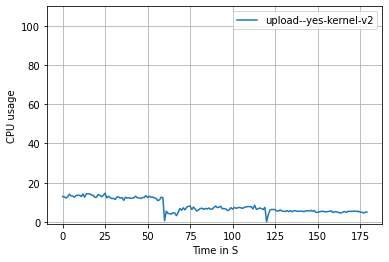

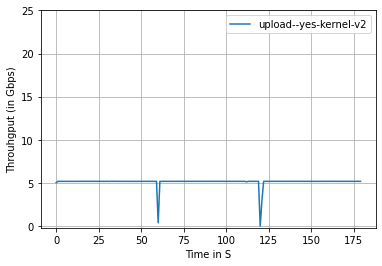

In [115]:
describe_test(res_dirs[0], cpu=-1, throuhgput='rxkB/s', 
              ylim_net=[-.2, 25], ylim_cpu=[-1, 110], client=5)

upload--no-kernel-v2
   client     used
0       1    2.000
1       5   79.125
2      10   79.470
3      15  266.315
4      20  421.175
5      25  556.095
   client    mean  median  90th  99th
0       1  0.2567    0.20  0.31  0.31
1       5  0.2779    0.26  0.40  0.40
2      10  0.2921    0.26  0.40  0.40
3      15  0.2967    0.26  0.42  0.42
4      20  0.3004    0.27  0.42  0.42
5      25  0.3445    0.30  0.46  0.46
upload--no-kernel-v2
   client     rxkB/s
0       1   1.037016
1       5   5.183151
2      10  10.367016
3      15  15.550071
4      20  20.733235
5      25  23.261533


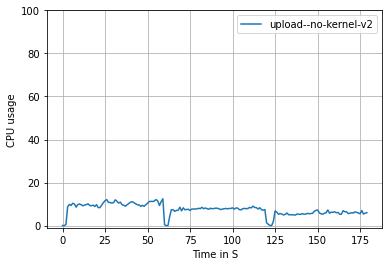

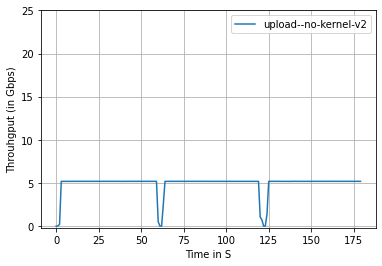

In [116]:
describe_test(res_dirs[1], cpu=-1, throuhgput='rxkB/s',
              ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=5)

In [118]:
diff_cpu, diff_lat, diff_net = compute_differences(res_dirs[2], res_dirs[0])

upload--partial-kernel-v2; upload--yes-kernel-v2 no - yes


CPU Difference
Absolute difference:
client
1     -1.802222
5     -3.267222
10    -7.874722
15    -6.171389
20    -6.771667
25   -14.484722
Name: used, dtype: float64

Relative difference:
client
1    -75.266821
5    -55.197334
10   -78.281880
15   -29.744819
20   -19.801642
25   -29.004411
Name: used, dtype: float64


Latency Difference
Absolute difference:
           mean  median   90th   99th
client                               
1       0.01020  0.0250 -0.030 -0.030
5       0.00640  0.0000 -0.040 -0.040
10     -0.08825 -0.0725 -0.105 -0.105
15     -0.03540 -0.0300 -0.020 -0.020
20     -0.01945 -0.0300 -0.050 -0.050
25     -0.02440 -0.0600 -0.080 -0.080

Relative difference:
             mean     median       90th       99th
client                                            
1        3.833145  12.500000  -7.142857  -7.142857
5        2.046690   0.000000  -8.510638  -8.510638
10     -21.193564 -20.138889 -18.918919 -18.918919

upload--yes-kernel
   client       used
0       1    22.5175
1      50  1100.8600
2     100   637.4500
   client      mean   median    90th    99th
0       1  0.409150  0.33500  0.4900  0.4900
1      50  0.342975  0.29500  0.4575  0.4575
2     100  0.420800  0.36375  0.6050  0.6050
upload--yes-kernel
   client     rxkB/s
0       1   0.258764
1      50  12.957364
2     100   8.255695


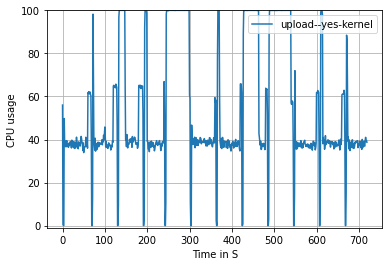

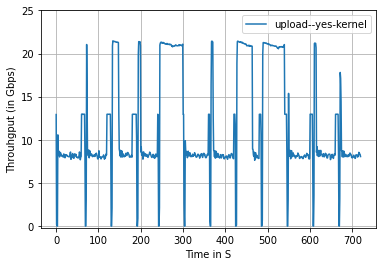

In [51]:
describe_test(res_dirs[4], throuhgput='rxkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=100)

upload--no-kernel
   client      used
0       1     9.780
1      50  1010.875
2     100   479.675
   client     mean  median    90th    99th
0       1  0.30125  0.2650  0.3850  0.3850
1      50  0.27235  0.2465  0.3700  0.3700
2     100  0.33750  0.3000  0.4675  0.4675
upload--no-kernel
   client     rxkB/s
0       1   0.258737
1      50  12.958190
2     100   8.439730


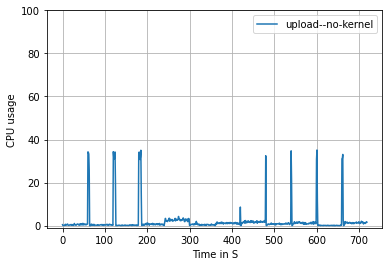

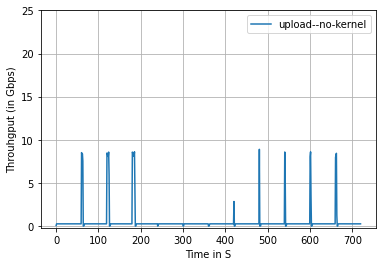

In [40]:
describe_test(res_dirs[6], throuhgput='rxkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=1)

In [41]:
diff_cpu, diff_lat, diff_net = compute_differences(res_dirs[0], res_dirs[1])

download--yes-kernel-threaded; download--no-kernel-threaded yes - no


CPU Difference
Absolute difference:
client
1       0.686250
50     12.773333
100     6.590972
Name: used, dtype: float64

Relative difference:
client
1      51.265823
50     21.107811
100    15.888667
Name: used, dtype: float64


Latency Difference
Absolute difference:
            mean  median    90th    99th
client                                  
1       0.046650  0.0450  0.0550  0.0550
50      0.013650  0.0275  0.0525  0.0525
100    -0.070925  0.0200 -0.1915 -0.1915

Relative difference:
             mean     median       90th       99th
client                                            
1       14.095785  16.981132  12.643678  12.643678
50       3.262233   9.565217   7.216495   7.216495
100    -10.114082   4.255319 -14.730769 -14.730769


Throuhgput Difference
Absolute difference:
client
1     -0.000334
50    -0.011318
100    0.740914
Name: txkB/s, dtype: float64

Relative difference:
client
1     -0.128812
50 

download--yes-kernel-threaded
   client      used
0       1    24.095
1      50  1089.265
2     100   746.680
   client      mean  median    90th    99th
0       1  0.330950  0.2650  0.4350  0.4350
1      50  0.418425  0.2875  0.7275  0.7275
2     100  0.701250  0.4700  1.3000  1.3000
download--yes-kernel-threaded
   client     txkB/s
0       1   0.259059
1      50  12.840696
2     100  10.007615


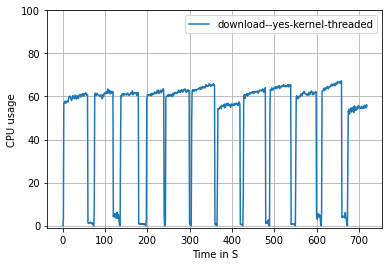

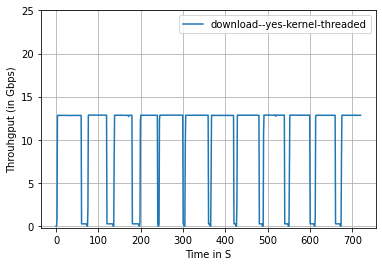

In [42]:
describe_test(res_dirs[0], throuhgput='txkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=50)

download--no-kernel-threaded
   client      used
0       1   11.7425
1      50  859.3450
2     100  628.0425
   client      mean  median    90th    99th
0       1  0.284300    0.22  0.3800  0.3800
1      50  0.404775    0.26  0.6750  0.6750
2     100  0.772175    0.45  1.4915  1.4915
download--no-kernel-threaded
   client     txkB/s
0       1   0.258726
1      50  12.829378
2     100  10.748529


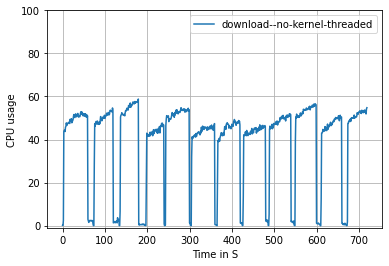

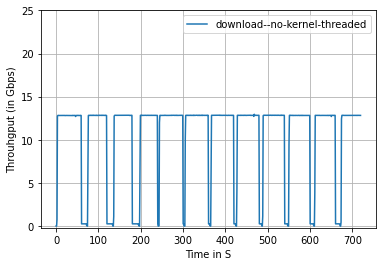

In [43]:
describe_test(res_dirs[1], throuhgput='txkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=50)

In [44]:
diff_cpu, diff_lat, diff_net = compute_differences(res_dirs[3], res_dirs[7])

download--yes-kernel; download--no-kernel yes - no


CPU Difference
Absolute difference:
client
1     -0.051250
50     9.757639
100    7.914028
Name: used, dtype: float64

Relative difference:
client
1      -3.396539
50     16.774349
100    18.169556
Name: used, dtype: float64


Latency Difference
Absolute difference:
            mean  median    90th    99th
client                                  
1       0.010350  -0.022 -0.0100 -0.0100
50      0.009350   0.015  0.0225  0.0225
100     0.007675   0.015 -0.0600 -0.0600

Relative difference:
            mean    median      90th      99th
client                                        
1       3.393443 -9.442060 -2.631579 -2.631579
50      2.489516  5.555556  3.896104  3.896104
100     1.326994  3.797468 -6.201550 -6.201550


Throuhgput Difference
Absolute difference:
client
1     -0.000157
50     0.000192
100    0.661667
Name: txkB/s, dtype: float64

Relative difference:
client
1     -0.060760
50     0.001485
100    6.303009
Name: txkB/s

download--yes-kernel
   client       used
0       1    27.1600
1      50  1047.0600
2     100   784.0175
   client      mean  median    90th    99th
0       1  0.305000   0.233  0.3800  0.3800
1      50  0.375575   0.270  0.5775  0.5775
2     100  0.578375   0.395  0.9675  0.9675
download--yes-kernel
   client     txkB/s
0       1   0.258920
1      50  12.956230
2     100  10.497634


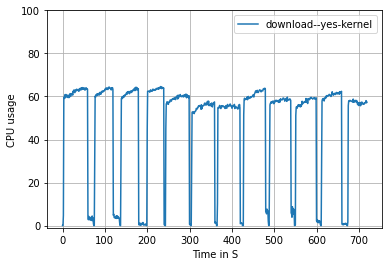

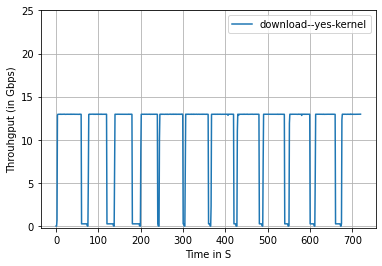

In [45]:
describe_test(res_dirs[3], throuhgput='txkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=50)

download--no-kernel
   client      used
0       1   28.0825
1      50  871.4225
2     100  641.5650
   client      mean  median    90th    99th
0       1  0.294650   0.255  0.3900  0.3900
1      50  0.366225   0.255  0.5550  0.5550
2     100  0.570700   0.380  1.0275  1.0275
download--no-kernel
   client     txkB/s
0       1   0.258762
1      50  12.956422
2     100  11.159301


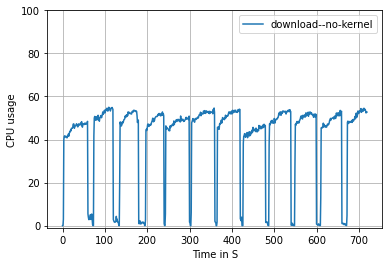

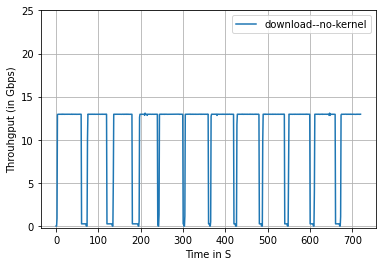

In [46]:
describe_test(res_dirs[7], throuhgput='txkB/s', ylim_net=[-.2, 25], ylim_cpu=[-1, 100], client=50)